In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from scipy.stats import gaussian_kde
import scipy.interpolate as sip
import scipy.integrate as cumtrapz
import h5py


Populating the interactive namespace from numpy and matplotlib


### set up mixture model for spin magnitude distribution

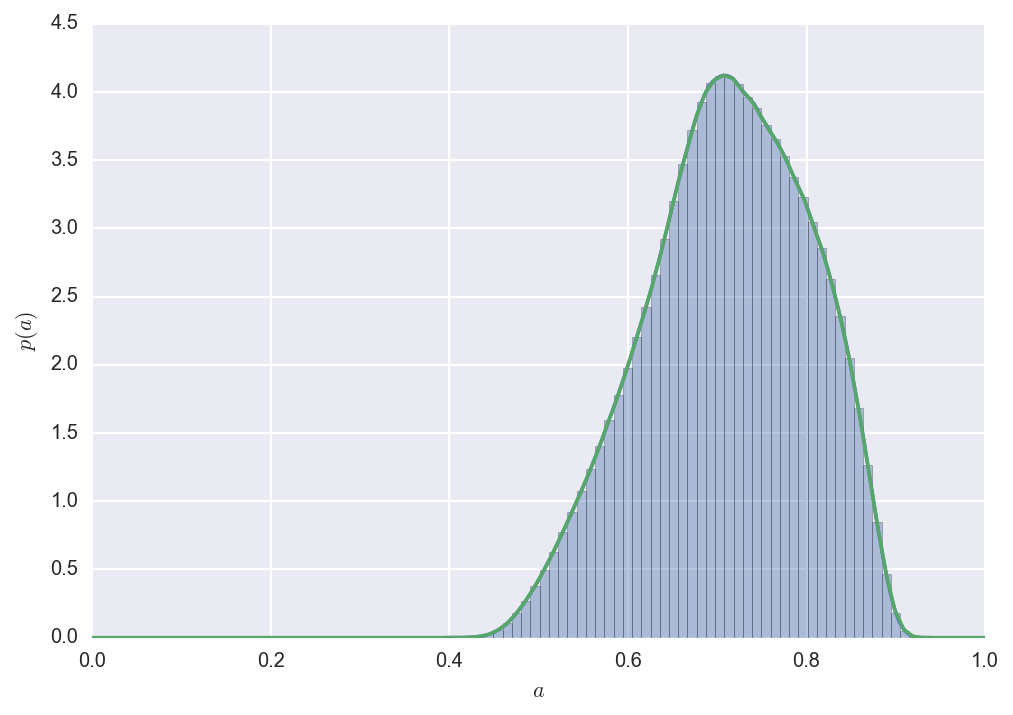

In [2]:
HM_spin_samples = loadtxt("/Users/mayafishbach/Desktop/BHspins/spin_for_plots/4HBRmerger_69_2500.txt") #change filepath appropriately
HM_spin_kde = gaussian_kde(HM_spin_samples)
sns.distplot(HM_spin_samples)
chis = linspace(0.,1.,100)
plt.plot(chis,HM_spin_kde(chis))
plt.xlabel(r'$a$')
plt.ylabel(r'$p(a)$')
plt.show()

In [3]:
HM_spin_interp = sip.interp1d(chis,HM_spin_kde(chis))

In [4]:
def pa1a2_mixture(a1,a2,f):
    return (f*HM_spin_interp(a1)+(1.-f))*(f*HM_spin_interp(a2)+(1.-f))

def pa1a2_mixture_smallspins(a1,a2,f):
    return (f*HM_spin_interp(a1)+(1.-f)*2.*(1.-a1))*(f*HM_spin_interp(a2)+(1.-f)*2.*(1.-a2))

def pa1a2_mixture_primary(a1,a2,f):
    return (f*HM_spin_interp(a1)+(1.-f))

### hierarchical Bayesian likelihood, assuming no selection effects

In [5]:
def loglikelihood(a1s,a2s,pa1a2):
    fs = linspace(0.0,1.0,100)
    ll_sum = zeros_like(fs)
    def onesysmeanl(a1,a2,f):
        return mean(pa1a2(a1,a2,f))
    def logl(f):
        ll = 0.0
        for a1, a2 in zip(a1s, a2s):
            res = log(onesysmeanl(a1, a2, f))
            ll += res
        return ll
    for i,f in enumerate(fs):
        ll_sum[i] = logl(f)
    return fs, ll_sum

### Read in samples

In [6]:
import glob
a1_list_SEOB = []
a2_list_SEOB = []
a1_list_IMRP = []
a2_list_IMRP = []
a1_list_comb = []
a2_list_comb = []
evt_names = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 
             'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823']
for evt_name in evt_names:
    fname = glob.glob("/Users/mayafishbach/Downloads/GWTC-1_sample_release/*"+evt_name+"*.hdf5")[0] #change file path
    with h5py.File(fname,'r') as inp:
        print fname
        a1_list_SEOB.append(array(inp['SEOBNRv3_posterior']['spin1']))
        a2_list_SEOB.append(array(inp['SEOBNRv3_posterior']['spin2']))
        a1_list_IMRP.append(array(inp['IMRPhenomPv2_posterior']['spin1']))
        a2_list_IMRP.append(array(inp['IMRPhenomPv2_posterior']['spin2']))
        a1_list_comb.append(array(inp['Overall_posterior']['spin1']))
        a2_list_comb.append(array(inp['Overall_posterior']['spin2']))

/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW150914_GWTC-1.hdf5
/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW151012_GWTC-1.hdf5
/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW151226_GWTC-1.hdf5
/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW170104_GWTC-1.hdf5
/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW170608_GWTC-1.hdf5
/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW170729_GWTC-1.hdf5
/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW170809_GWTC-1.hdf5
/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW170814_GWTC-1.hdf5
/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW170818_GWTC-1.hdf5
/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW170823_GWTC-1.hdf5


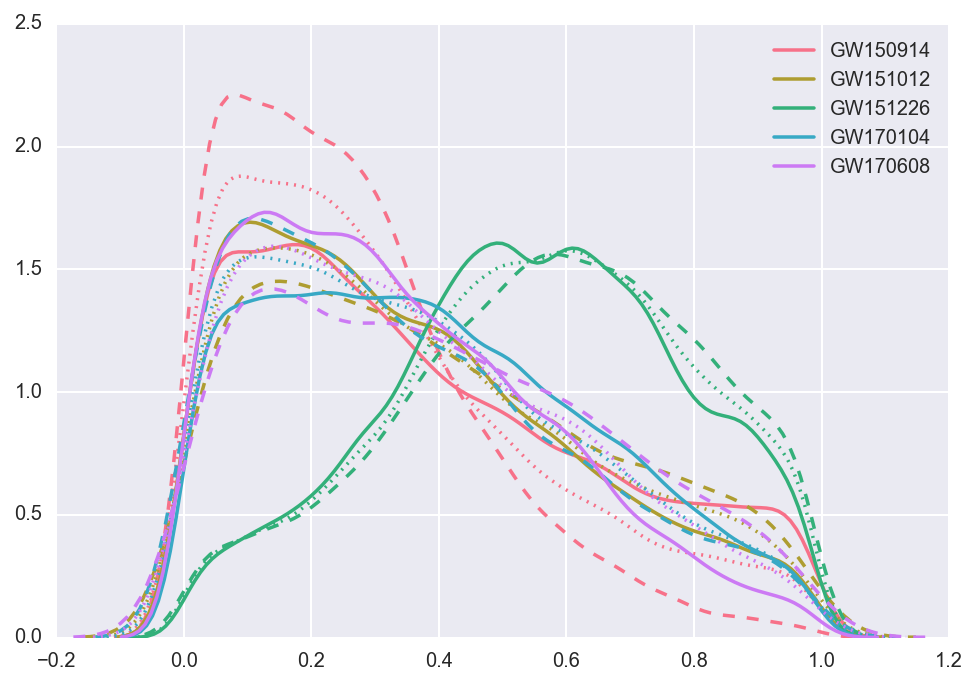

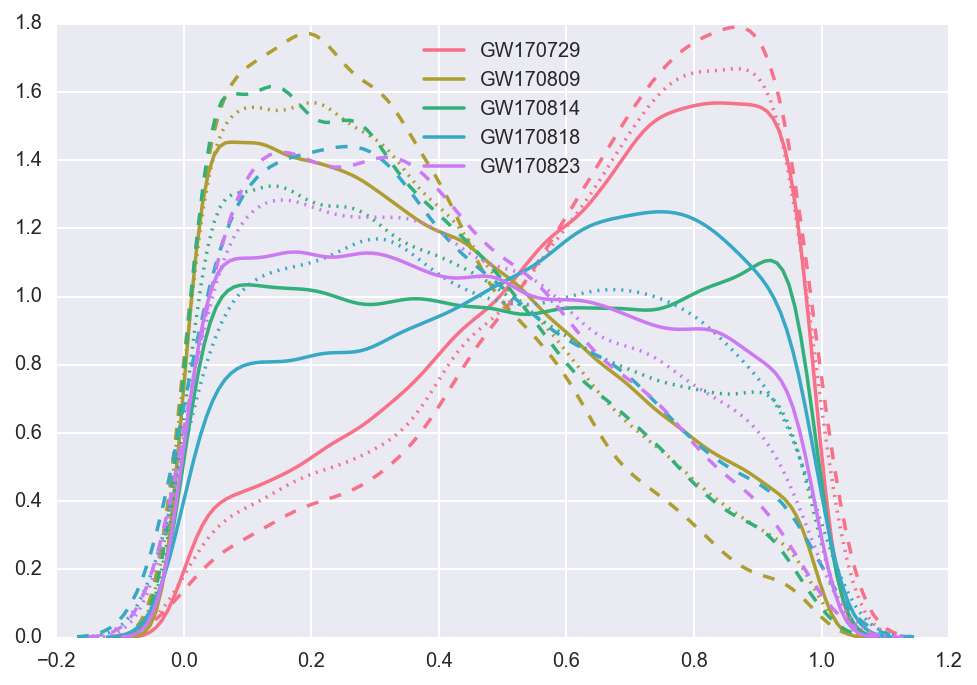

In [7]:
sns.set_palette('husl',5)
for i in range(5):
    sns.kdeplot(a1_list_IMRP[i],label=evt_names[i])
    sns.kdeplot(a1_list_SEOB[i],ls='--',c=sns.color_palette()[i])
    sns.kdeplot(a1_list_comb[i],ls=':',c=sns.color_palette()[i])
plt.legend(loc='best')
plt.show()
for i in range(5):
    sns.kdeplot(a1_list_IMRP[i+5],label=evt_names[i+5])
    sns.kdeplot(a1_list_SEOB[i+5],ls='--',c=sns.color_palette()[i])
    sns.kdeplot(a1_list_comb[i+5],ls=':',c=sns.color_palette()[i])
plt.legend(loc='best')
plt.show()

### calculate posterior on f, the mixing fraction for different models and different sets of PE samples

In [8]:
fs, ll_sum_mixture_IMRP = loglikelihood(a1_list_IMRP,a2_list_IMRP,pa1a2_mixture)
fs, ll_sum_mixture_SEOB = loglikelihood(a1_list_SEOB,a2_list_SEOB,pa1a2_mixture)
fs, ll_sum_mixture_comb = loglikelihood(a1_list_comb,a2_list_comb,pa1a2_mixture)

In [9]:
fs, ll_sum_mixture_low_IMRP = loglikelihood(a1_list_IMRP,a2_list_IMRP,pa1a2_mixture_smallspins)
fs, ll_sum_mixture_low_SEOB = loglikelihood(a1_list_SEOB,a2_list_SEOB,pa1a2_mixture_smallspins)
fs, ll_sum_mixture_low_comb = loglikelihood(a1_list_comb,a2_list_comb,pa1a2_mixture_smallspins)

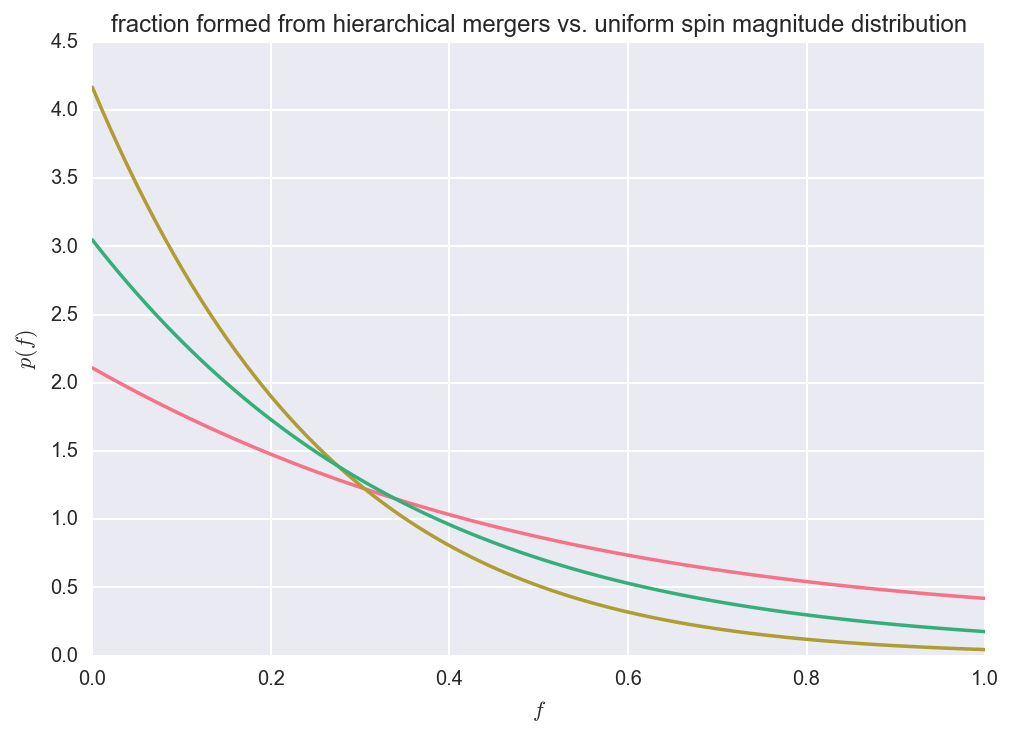

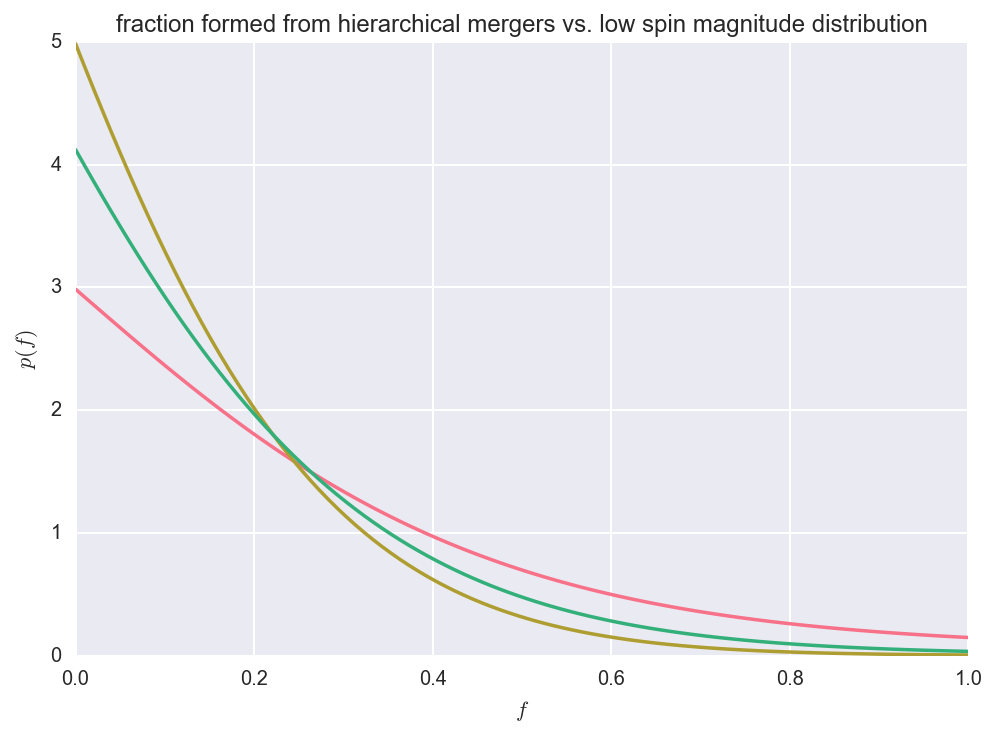

In [11]:
plt.plot(fs,exp(ll_sum_mixture_IMRP)/trapz(exp(ll_sum_mixture_IMRP),fs),label='IMRP samples')
plt.plot(fs,exp(ll_sum_mixture_SEOB)/trapz(exp(ll_sum_mixture_SEOB),fs),label='SEOB samples')
plt.plot(fs,exp(ll_sum_mixture_comb)/trapz(exp(ll_sum_mixture_comb),fs),label='combined samples')
plt.xlabel('$f$')
plt.ylabel('$p(f)$')
plt.title('fraction formed from hierarchical mergers vs. uniform spin magnitude distribution')
plt.show()

plt.plot(fs,exp(ll_sum_mixture_low_IMRP)/trapz(exp(ll_sum_mixture_low_IMRP),fs),label='IMRP asmples')
plt.plot(fs,exp(ll_sum_mixture_low_SEOB)/trapz(exp(ll_sum_mixture_low_SEOB),fs),label='SEOB samples')
plt.plot(fs,exp(ll_sum_mixture_low_comb)/trapz(exp(ll_sum_mixture_low_comb),fs),label='combined samples')
plt.title('fraction formed from hierarchical mergers vs. low spin magnitude distribution')
plt.xlabel('$f$')
plt.ylabel('$p(f)$')
plt.show()

### the ratio p(f=1)/p(f=0) gives odds ratio between the two models

In [12]:
print exp(ll_sum_mixture_IMRP[0]-ll_sum_mixture_IMRP[-1])
print exp(ll_sum_mixture_SEOB[0]-ll_sum_mixture_SEOB[-1])
print exp(ll_sum_mixture_comb[0]-ll_sum_mixture_comb[-1])

5.02968121618
94.6884220434
17.3223210087


In [13]:
print exp(ll_sum_mixture_low_IMRP[0]-ll_sum_mixture_low_IMRP[-1])
print exp(ll_sum_mixture_low_SEOB[0]-ll_sum_mixture_low_SEOB[-1])
print exp(ll_sum_mixture_low_comb[0]-ll_sum_mixture_low_comb[-1])

20.2459106923
1029.59926547
120.096511399


### Reading in data for the BNS 

This is the data relevant for the H0 measurement

Use either the distance samples from the analysis with the high spin prior (called simply distance below) or the distance from the low spin prior analysis (distance_lowspin)

/Users/mayafishbach/anaconda/envs/galaxies/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/mayafishbach/anaconda/envs/galaxies/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


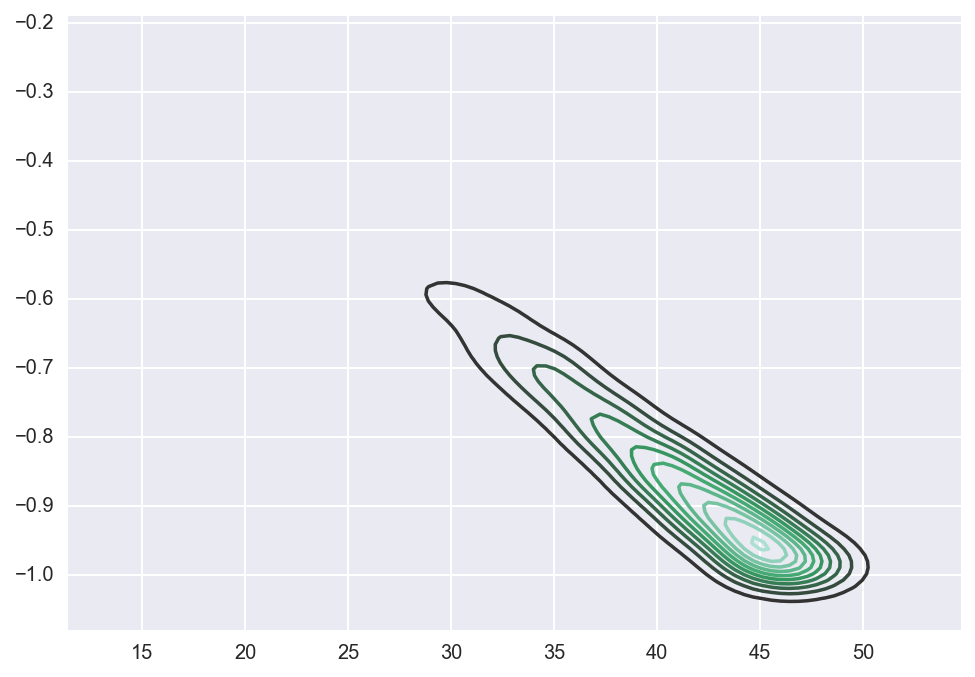

In [14]:
with h5py.File('/Users/mayafishbach/Downloads/GWTC-1_sample_release/GW170817_GWTC-1.hdf5','r') as inp: #change file path appropriately
    distance = array(inp['IMRPhenomPv2NRT_highSpin_posterior']['luminosity_distance_Mpc'])
    cosinc = array(inp['IMRPhenomPv2NRT_highSpin_posterior']['costheta_jn'])
    distance_lowspin = array(inp['IMRPhenomPv2NRT_lowSpin_posterior']['luminosity_distance_Mpc'])
sns.kdeplot(distance,cosinc)

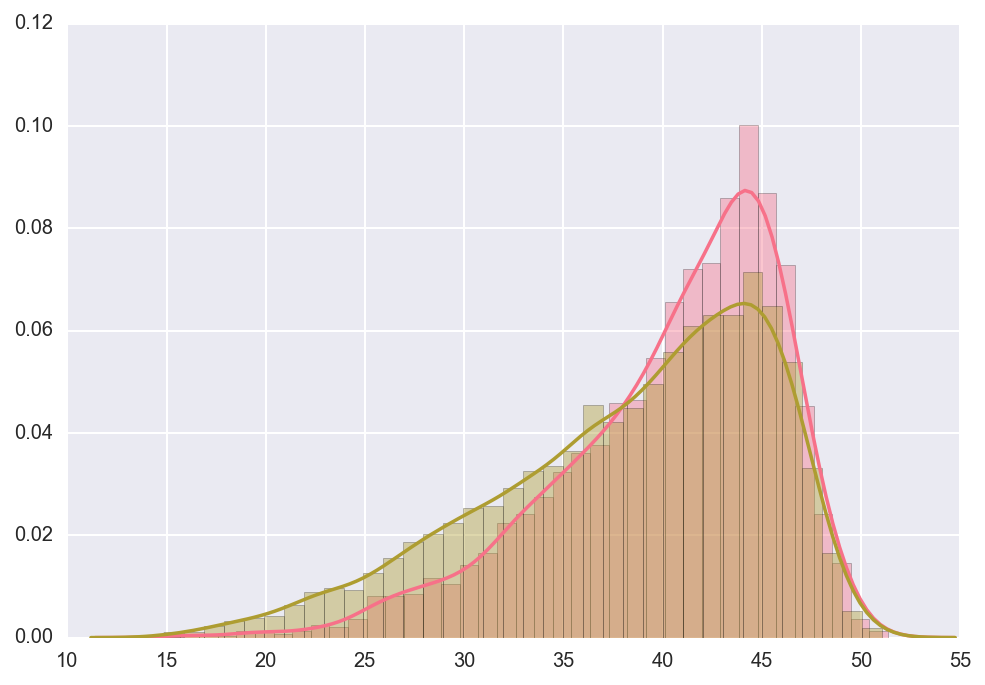

In [15]:
sns.distplot(distance)
sns.distplot(distance_lowspin)